# Value at Risk

In [2]:
import yfinance as yf
import datetime
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Historical Value At Risk 
### Question is investing in Stock X 1000$ every day what is Var at confidence interval of 95%

[*********************100%%**********************]  1 of 1 completed

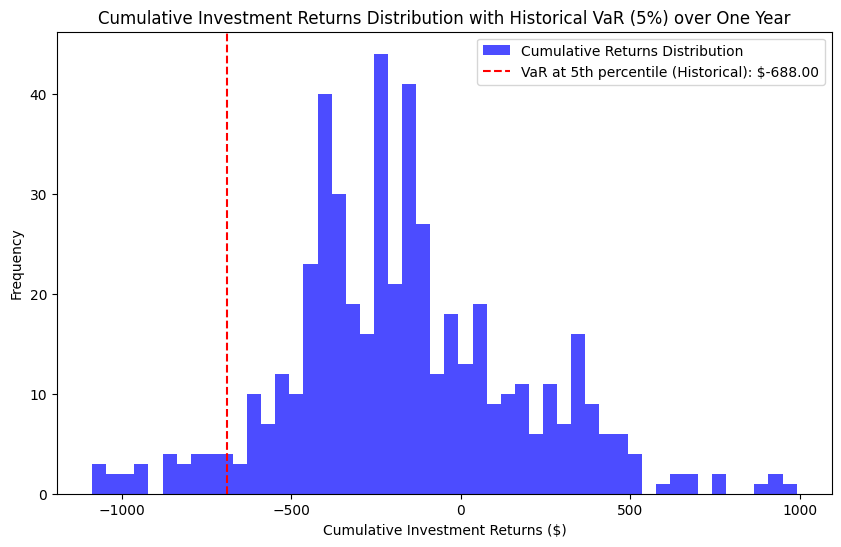

In [5]:
# Fetch historical data (fetching more data for a robust calculation)
data = yf.download('TSLA', start='2022-01-01', end='2023-12-31')
data['Returns'] = data['Close'].pct_change()

# Daily investment
daily_investment = 1000

# Calculate daily investment returns
data['InvestmentReturns'] = data['Returns'] * daily_investment
# Return is calculated as log of the ratio of the current day's close price to the previous day's close price
# data['InvestmentReturns'] = np.log(data['Close'] / data['Close'].shift(1))

# Calculate cumulative returns for 252 days (approx. one trading year)
data['CumulativeInvestmentReturns'] = data['InvestmentReturns'].rolling(min_periods=1, window=252).sum()

# Drop NA values
data = data.dropna()

# Historical VaR(95) on cumulative returns
var_95_hist = data['CumulativeInvestmentReturns'].quantile(0.05)

# Plotting
plt.figure(figsize=(10, 6))
plt.hist(data['CumulativeInvestmentReturns'], bins=50, alpha=0.7, color='blue', label='Cumulative Returns Distribution')

# Draw VaR line
plt.axvline(x=var_95_hist, color='red', linestyle='--', label=f'VaR at 5th percentile (Historical): ${var_95_hist:.2f}')
plt.title('Cumulative Investment Returns Distribution with Historical VaR (5%) over One Year')
plt.xlabel('Cumulative Investment Returns ($)')
plt.ylabel('Frequency')
plt.legend()

plt.show()

In [4]:
print(f'Historical VaR(95) on cumulative returns: ${var_95_hist:.2f}')

Historical VaR(95) on cumulative returns: $-0.91


# Now we do multiple Stock in see whether Var is still negative


In [6]:
import yfinance as yf
import pandas as pd
import numpy as np

# Fetch historical data for two tickers
ticker_symbols = ['TSLA', 'AAPL']
data = yf.download(ticker_symbols, start='2020-01-01', end='2023-12-31')['Close']

# Calculate daily returns
returns = data.pct_change().dropna()

# Portfolio weights (assuming equal weighting for simplicity)
weights = np.array([0.5, 0.5])

# Calculate portfolio returns
portfolio_returns = returns.dot(weights)

# Calculate cumulative returns for 252 days (approx. one trading year)
portfolio_returns['CumulativePortfolioReturns'] = portfolio_returns.rolling(min_periods=1, window=252).sum()

# Historical VaR(95) on cumulative portfolio returns
var_95_hist_portfolio = portfolio_returns['CumulativePortfolioReturns'].quantile(0.05)

print(f"Historical Cumulative Portfolio VaR(95) over One Year: ${var_95_hist_portfolio:.2f}")


[*********************100%%**********************]  2 of 2 completed

Historical Cumulative Portfolio VaR(95) over One Year: $-0.23


# We can see that If we expand portfolio var might change

In [7]:
def generate_diversified_weights(num_assets, max_weight=0.20):
    # Enforce that no weight is above the max_weight threshold
    weights = np.random.random(num_assets)
    while max(weights) > max_weight:
        weights = np.random.random(num_assets)
    return weights / np.sum(weights)

# Tickers
tickers = ['AAPL', 'AMZN', 'PFE', 'WMT', 'CSCO']

# Fetch historical data
data = yf.download(tickers, start='2020-01-01', end='2023-12-31')['Close']

# Calculate daily returns
returns = data.pct_change().dropna()

# Number of portfolios to simulate
num_portfolios = 10000

# Daily investment and total investment
daily_investment = 1000
total_days = returns.shape[0]
total_investment = daily_investment * total_days

# Array to store results and weights
results = np.zeros((5 + len(tickers), num_portfolios))  # Added len(tickers) for weights, and extra rows for total value and capital gain/loss

for i in range(num_portfolios):
    # Generate diversified weights
    weights = generate_diversified_weights(len(tickers))
    
    # Calculate expected portfolio return and scale by total investment
    portfolio_return = np.sum(weights * returns.mean()) * total_days * daily_investment
    
    # Calculate expected portfolio volatility and scale by total investment
    portfolio_stddev = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * total_days, weights))) * daily_investment
    
    # Calculate portfolio VaR: Value at Risk at 95% confidence level, and scale by total investment
    portfolio_var = norm.ppf(0.05, portfolio_return, portfolio_stddev)
    
    # Store results in the results array
    results[0,i] = portfolio_return
    results[1,i] = portfolio_stddev
    results[2,i] = portfolio_var
    results[3,i] = results[0,i] / results[1,i]  # Store Sharpe Ratio (return / volatility)
    total_value_end = total_investment + portfolio_return
    results[4,i] = total_value_end  # Store Total Portfolio Value at end
    # Store weights
    for j in range(len(weights)):
        results[j+5,i] = weights[j]

# Convert results array to Pandas DataFrame
columns = ['Ret', 'Std', 'VaR', 'Sharpe', 'TotalValue'] + [ticker + "_weight" for ticker in tickers]
results_frame = pd.DataFrame(results.T, columns=columns)

# Format the data for better readability
pd.options.display.float_format = '{:,.2f}'.format

# Print results
print("Diversified Portfolio with Highest Sharpe Ratio:")
print(results_frame.iloc[results_frame['Sharpe'].idxmax()])

# Print top 10 diversified portfolios with the highest returns
print("\nTop 10 Diversified Portfolios with Maximum Returns:")
print(results_frame.nlargest(10, 'Ret'))


[*********************100%%**********************]  5 of 5 completed


Diversified Portfolio with Highest Sharpe Ratio:
Ret               1,035.63
Std                 606.35
VaR                  38.27
Sharpe                1.71
TotalValue    1,006,035.63
AAPL_weight           0.84
AMZN_weight           0.02
PFE_weight            0.03
WMT_weight            0.02
CSCO_weight           0.09
Name: 687, dtype: float64

Top 10 Diversified Portfolios with Maximum Returns:
          Ret    Std    VaR  Sharpe   TotalValue  AAPL_weight  AMZN_weight  \
687  1,035.63 606.35  38.27    1.71 1,006,035.63         0.84         0.02   
558    957.66 578.39   6.28    1.66 1,005,957.66         0.71         0.11   
7331   950.56 583.74  -9.61    1.63 1,005,950.56         0.76         0.05   
7162   906.36 589.52 -63.31    1.54 1,005,906.36         0.52         0.36   
1675   899.07 579.79 -54.60    1.55 1,005,899.07         0.57         0.28   
920    898.35 583.61 -61.60    1.54 1,005,898.35         0.52         0.35   
3638   896.90 556.00 -17.65    1.61 1,005,896.90        